# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import glob
import os

#from glob import glob
import pickle
from pickle import dump,load
from sys import getsizeof
# Date and Time 
import datetime,time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


#Read/Display  images
from skimage import io
from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import Input, layers, Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import keras
from keras.preprocessing.text import Tokenizer


from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D,Bidirectional,Add

#from keras.layers.wrappers import Bidirectional
#from keras.layers.wrappers import Bidirectional
from keras import optimizers
#from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_360/3264521061.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


In [2]:
 tf. __version__

'2.7.0'

In [3]:
## Check GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10442105426711823961
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23961468928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9124773605346149394
physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-09-20 18:14:09.281075: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-20 18:14:09.281136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable
DATA_DIR = "/datasets/flickr/"
images=os.path.join(DATA_DIR,'Images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


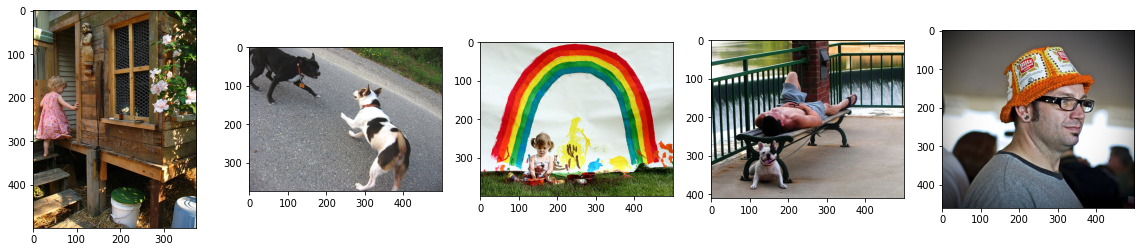

In [5]:
#Visualise both the images & text present in the dataset
Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)


In [6]:
#Import the dataset and read the text file into a seperate variable
text_file = '/datasets/flickr/captions.txt'
def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read() #for reading the content of the file
    print(text)
    open_file.close()    
    return text

doc = load_doc(text_file)
print(doc[:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
image_path='/datasets/flickr/Images/'
INPUT_PATH='/Capstone/'
all_img_id= [] #store all the image id here
all_img_vector=[] #store all the image path here
annotations=[] #store all the captions here
with open('/datasets/flickr/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,/datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,/datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
...,...,...,...
40450,997722733_0cb5439472.jpg,/datasets/flickr/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/datasets/flickr/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,/datasets/flickr/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles
40453,997722733_0cb5439472.jpg,/datasets/flickr/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


In [8]:
type(annotations)

list

In [9]:
len(annotations)

40455

In [10]:
#Create a list which contains all the captions
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations] #write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [11]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

In [12]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in annotations for word in line.split()] #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '<end>': 40455,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         

<start> :  40455
<end> :  40455
a :  38716
A :  21480
in :  18170
the :  14587
on :  10354
is :  9069
and :  8057
dog :  7804
with :  7303
man :  6727
of :  6495
Two :  3962
white :  3646
black :  3491
boy :  3395
are :  3364
girl :  3174
woman :  3146
to :  3005
The :  2919
wearing :  2916
at :  2809
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
his :  2255


Text(0, 0.5, 'Counts')

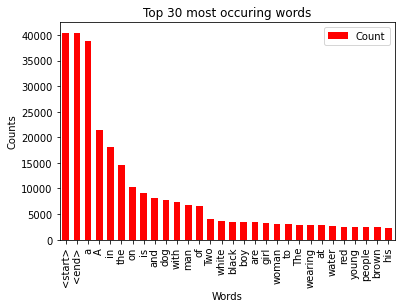

In [13]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

#write your code here

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer

#your code here
top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [15]:
# Create word-to-index and index-to-word mappings.

#your code here
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [16]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4],
 [3, 2, 20, 313, 64, 2, 197, 120, 4],
 [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4],
 [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4],
 [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]

In [17]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

In [18]:
tokenizer.oov_token

'<unk>'

In [19]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'people',
 24: 'at',
 25: 'water',
 26: 'young',
 27: 'red',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'shirt',
 37: 'while',
 38: 'down',
 39: 'little',
 40: 'standing',
 41: 'ball',
 42: 'grass',
 43: 'person',
 44: 'child',
 45: 'snow',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'small',
 52: 'up',
 53: 'field',
 54: 'holding',
 55: 'large',
 56: 'group',
 57: 'by',
 58: 'green',
 59: 'yellow',
 60: 'children',
 61: 'walking',
 62: 'men',
 63: 'her',
 64: 'into',
 65: 'beach',
 66: 'air',
 67: 'near',
 68: 'jumps',
 69: 'mouth',
 70: 'street',
 71: 'runs',
 72: 'for',
 73: 'another',
 74: 'riding',
 75: 'fro

In [20]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 61436),
             ('child', 1517),
             ('in', 18193),
             ('pink', 706),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 495),
             ('up', 1251),
             ('set', 106),
             ('of', 6504),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 51),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17677),
             ('to', 3008),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3641),
             ('dog', 7958),
             ('and', 8066),
             ('spotted', 37),
             ('are', 3365),
             ('fighting', 131),
             ('tri', 12),
             ('color

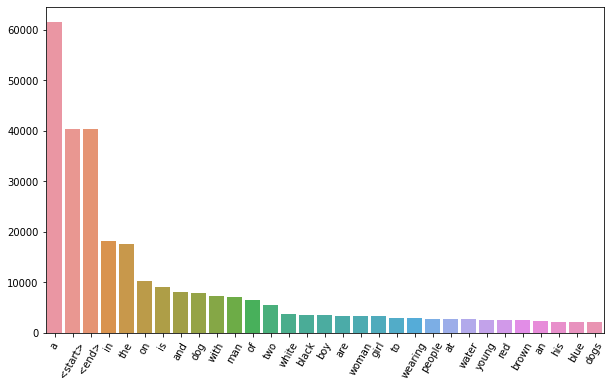

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
#your code here
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [22]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='blue')

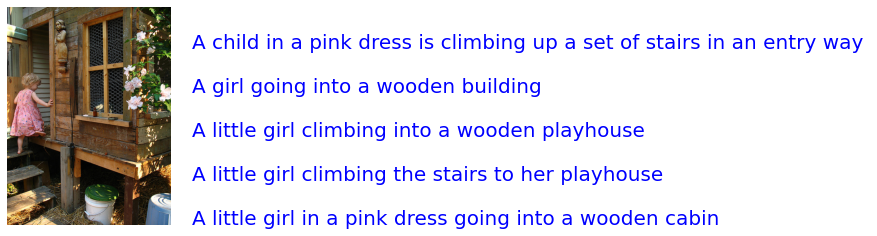

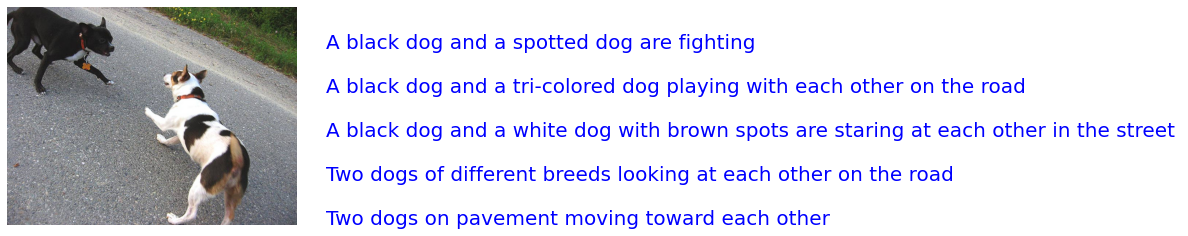

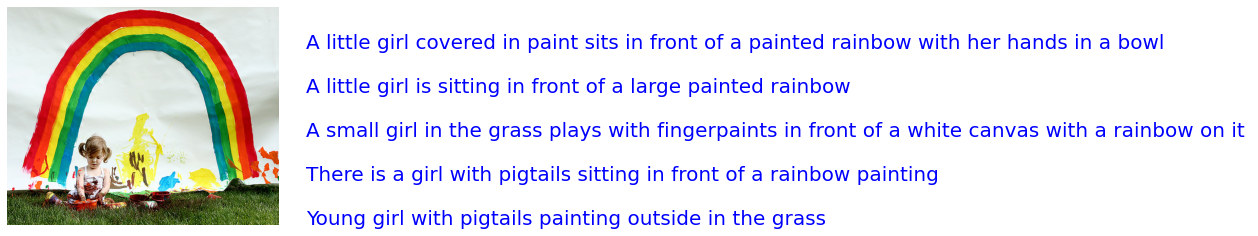

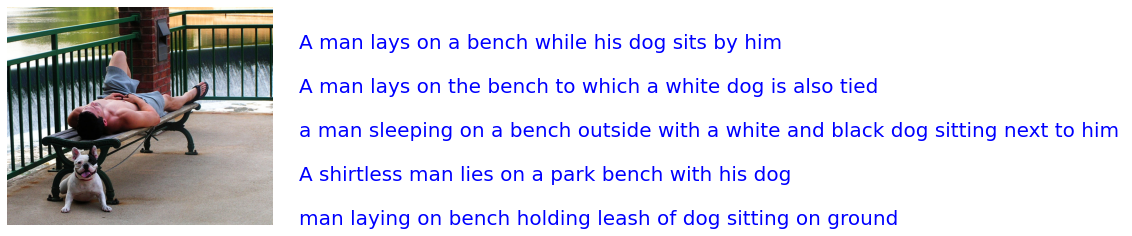

In [23]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,4,df)

In [24]:
# Function to find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_l= max_length

In [25]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector
caption_vector= padding_train_sequences(train_seqs,max_length,'post') #your code here

print("The shape of Caption vector is :" + str(caption_vector.shape))

The shape of Caption vector is :(40455, 35)


In [26]:
caption_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 39, ...,  0,  0,  0],
       ...,
       [ 3,  2, 43, ...,  0,  0,  0],
       [ 3,  2, 83, ...,  0,  0,  0],
       [ 3,  2, 83, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [27]:
#write your code here to create the dataset consisting of image paths

In [28]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)    
    return img, image_path

2023-09-20 18:14:12.998745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


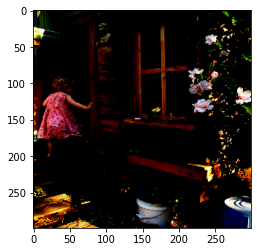

In [29]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

plt.imshow(load_image(all_img_path[0])[0])



In [30]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [31]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [32]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [33]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [34]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:34<00:00,  7.37it/s]


In [35]:
batch_f.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [36]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [37]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [38]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,capt): # your input variable goes here):
  img_tensor = feature_dict[image_name.decode('utf-8')] # write your code here to extract the features from the dictionary stored earlier
  return img_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [39]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data): #your input variables):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [40]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [41]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [42]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [43]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #self.dense = #build your Dense layer with relu activation
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)        
    def call(self, features):
        features = self.fc(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [44]:
encoder=Encoder(embedding_dim)

### Attention model

In [45]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =layers.Dense(units) #build your Dense layer
        self.W2 = layers.Dense(units) #build your Dense layer
        self.V = layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =  keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [46]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)  #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build your Dense layer
        self.d2 = layers.Dense(vocab_size) #build your Dense layer
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x))  # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state =self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [47]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [48]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [49]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [50]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [51]:
checkpoint_path_ckpt = INPUT_PATH +'checkpoint1/'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [54]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

In [55]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
    
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps    
    return avg_test_loss

In [56]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [03:33<49:42, 213.05s/it]

For epoch: 1, the train loss is 1.259, & test loss is 1.067
Time taken for 1 epoch 212.91924953460693 sec

Test loss has been reduced from 100.000 to 1.067


 13%|█▎        | 2/15 [05:12<31:42, 146.31s/it]

For epoch: 2, the train loss is 0.990, & test loss is 0.947
Time taken for 1 epoch 99.43510746955872 sec

Test loss has been reduced from 1.067 to 0.947


 20%|██        | 3/15 [06:50<24:50, 124.23s/it]

For epoch: 3, the train loss is 0.902, & test loss is 0.873
Time taken for 1 epoch 97.78630757331848 sec

Test loss has been reduced from 0.947 to 0.873


 27%|██▋       | 4/15 [08:28<20:52, 113.90s/it]

For epoch: 4, the train loss is 0.838, & test loss is 0.815
Time taken for 1 epoch 97.90047407150269 sec

Test loss has been reduced from 0.873 to 0.815


 33%|███▎      | 5/15 [10:05<17:58, 107.89s/it]

For epoch: 5, the train loss is 0.787, & test loss is 0.767
Time taken for 1 epoch 97.05340433120728 sec

Test loss has been reduced from 0.815 to 0.767


 40%|████      | 6/15 [11:43<15:40, 104.55s/it]

For epoch: 6, the train loss is 0.741, & test loss is 0.721
Time taken for 1 epoch 97.8813989162445 sec

Test loss has been reduced from 0.767 to 0.721


 47%|████▋     | 7/15 [13:21<13:38, 102.36s/it]

For epoch: 7, the train loss is 0.699, & test loss is 0.680
Time taken for 1 epoch 97.67860245704651 sec

Test loss has been reduced from 0.721 to 0.680


 53%|█████▎    | 8/15 [14:59<11:46, 100.88s/it]

For epoch: 8, the train loss is 0.660, & test loss is 0.642
Time taken for 1 epoch 97.52419638633728 sec

Test loss has been reduced from 0.680 to 0.642


 60%|██████    | 9/15 [16:37<09:59, 99.91s/it] 

For epoch: 9, the train loss is 0.626, & test loss is 0.608
Time taken for 1 epoch 97.6239001750946 sec

Test loss has been reduced from 0.642 to 0.608


 67%|██████▋   | 10/15 [18:14<08:16, 99.22s/it]

For epoch: 10, the train loss is 0.594, & test loss is 0.577
Time taken for 1 epoch 97.48058438301086 sec

Test loss has been reduced from 0.608 to 0.577


 73%|███████▎  | 11/15 [19:52<06:34, 98.70s/it]

For epoch: 11, the train loss is 0.565, & test loss is 0.548
Time taken for 1 epoch 97.36032819747925 sec

Test loss has been reduced from 0.577 to 0.548


 80%|████████  | 12/15 [21:30<04:55, 98.41s/it]

For epoch: 12, the train loss is 0.538, & test loss is 0.523
Time taken for 1 epoch 97.5848286151886 sec

Test loss has been reduced from 0.548 to 0.523


 87%|████████▋ | 13/15 [23:07<03:16, 98.01s/it]

For epoch: 13, the train loss is 0.514, & test loss is 0.498
Time taken for 1 epoch 96.91820025444031 sec

Test loss has been reduced from 0.523 to 0.498


 93%|█████████▎| 14/15 [24:44<01:37, 97.87s/it]

For epoch: 14, the train loss is 0.491, & test loss is 0.477
Time taken for 1 epoch 97.37025880813599 sec

Test loss has been reduced from 0.498 to 0.477


100%|██████████| 15/15 [26:22<00:00, 105.51s/it]

For epoch: 15, the train loss is 0.471, & test loss is 0.460
Time taken for 1 epoch 97.57167673110962 sec

Test loss has been reduced from 0.477 to 0.460


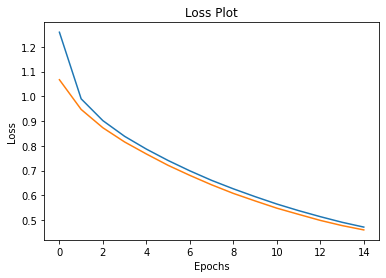

In [57]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [58]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()  #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [59]:
def beam_evaluate(image, beam_index =5): #your value for beam index):

    #write your code to evaluate the result using beam search
    max_length= max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])

    return final_caption



In [60]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [61]:
from nltk.translate.bleu_score import sentence_bleu

In [62]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [63]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

BELU score: 20.683507599800766
Real Caption: a couple of dogs running through the water with trees in the background
Prediction Caption: two dogs run through the water with trees in the water with trees in the water with trees in the water with trees in the water with trees in the water with trees in


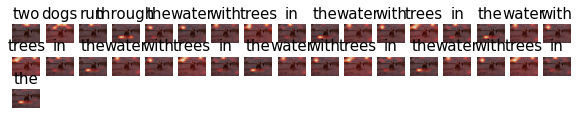

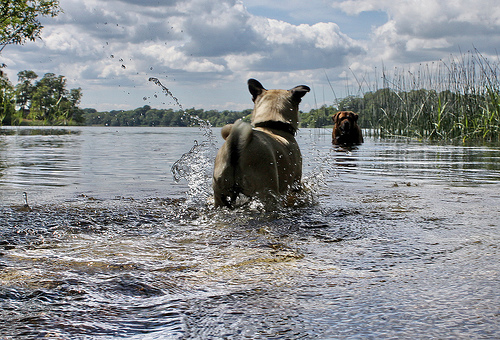

In [64]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.5, 0.5, 0, 0)) #set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [65]:
captions=beam_evaluate(test_image)
print(captions)

a dogs running through the water


BELU score: 44.99364491987482
Real Caption: small girl in pink clothing holding a camera in her hands
Prediction Caption: a girl in red clothing holding a camera


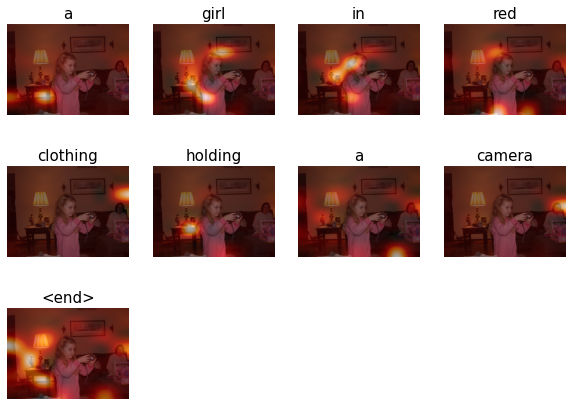

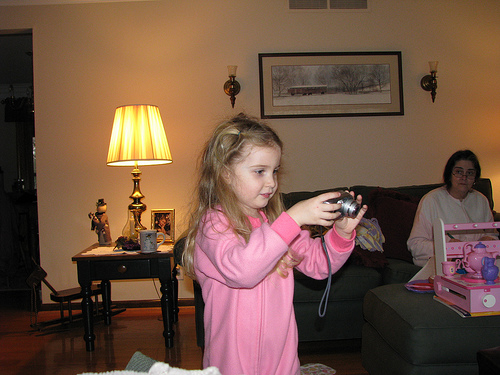

In [66]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption2=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption2.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption2)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [67]:
captions=beam_evaluate(test_image)
print(captions)

a little is a doorway with a woman are standing on the doorway with a woman are standing on the doorway with a woman are standing on the doorway with a woman are standing


BELU score: 37.01856698591431
Real Caption: a man and a small boy sit and rest against a stone wall
Prediction Caption: a man and a boy sit on the ground


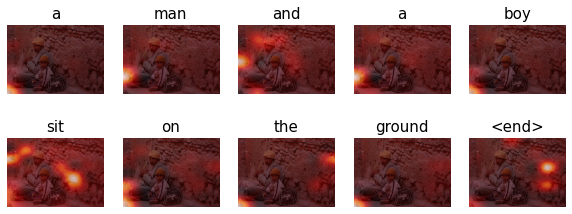

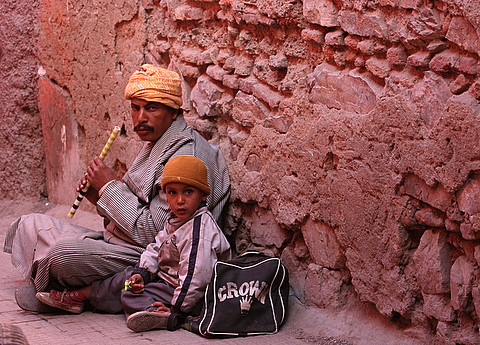

In [68]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption3=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption3.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption3)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [69]:
captions=beam_evaluate(test_image)
print(captions)

a man sit a ground


# Caption to Audio generation (Text to Speech) part

In [70]:
! pip install gTTS

  Using cached gTTS-2.3.2-py3-none-any.whl (28 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [71]:
# Import the required module for text to speech conversion
from gtts import gTTS
from IPython.display import Audio
tts = gTTS("Predicted Caption is: "+ pred_caption2) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)